In [7]:
import numpy as np
import pandas as pd

In [8]:
pd.read_table("Wiki-Vote.txt")

,i,o
0,30,1412
1,30,3352
2,30,5254
3,30,5543
4,30,7478
...,...,...
103684,8272,4940
103685,8273,4940
103686,8150,8275
103687,8150,8276


In [2]:
today_num = int(pd.Timestamp.today().date().strftime("%Y%m%d"))
offset = 0
print(f"our seed is {today_num + offset}")
np.random.seed(today_num + offset)
n = 2000
m = 1000
k = 20
our_dtype = 'float32'

V_orig = np.random.rand(n,m).astype(our_dtype)
V_orig = V_orig / V_orig.sum().sum() * k

our seed is 20230713


In [3]:
def init_klnmf(V, k, seed = 1, eps = 1e-8):
    
    np.random.seed(seed)
    n,m = V.shape
    W = np.random.rand(n, k).astype(our_dtype)
    H = np.random.rand(k, m).astype(our_dtype)
    A = V / (W @ H)    
    H = H * (W.T @ A) / W.sum(axis = 0, keepdims = True).T
    A = V / (W @ H)    
    W = W * (A @ H.T) / H.sum(axis = 1, keepdims = True).T
    
    H = H / H.sum(axis = 1, keepdims = True)
    W = W / W.sum(axis = 0, keepdims = True)
    return W, H, A

In [4]:
W_mat, H_mat, A_mat = init_klnmf(V_orig, k)

In [5]:
def run_mu(V, k, seed = 1, num_iter = 100, num_print = 10, eps = 1e-8):
    
    W, H, A = init_klnmf(V, k, seed = seed, eps = eps)
    
    np.random.seed(seed * 2023)
    
    obj_func = np.zeros(num_iter)
    obj_intercept = k * np.log(k) - k + 1
    
    for i in range(num_iter):
        if i > 0:
            #
            #A = V / (W @ H)
            H = H * (W.T @ A) / W.sum(axis = 0, keepdims = True).T
            #
            A = V / (W @ H)
            W = W * (A @ H.T) / H.sum(axis = 1, keepdims = True).T
            #
            A = V / (W @ H)
        else:
            A = V / (W @ H)
        obj_func[i] = obj_intercept + (V * np.log(A + eps)).sum().sum()
        if i == 0:
            print(f"init: obj {obj_func[i]}")
        elif i % num_print == num_print-1:
            print(f"round {i+1}: obj {obj_func[i]}")
    return W, H, A, obj_func

In [6]:
def run_mu_with_normalize(V, k, seed = 1, num_iter = 100, num_print = 10, eps = 1e-8):
    
    W, H, A = init_klnmf(V, k, seed = seed, eps = eps)
    
    np.random.seed(seed * 2023)
    
    obj_func = np.zeros(num_iter)
    obj_intercept = k * np.log(k) - k + 1
    
    for i in range(num_iter):
        if i > 0:
            #
            #A = V / (W @ H)
            H = H * (W.T @ A) / W.sum(axis = 0, keepdims = True).T
            H = H / H.sum(axis = 1, keepdims = True)
            #
            A = V / (W @ H)
            W = W * (A @ H.T) / H.sum(axis = 1, keepdims = True).T
            W = W / W.sum(axis = 0, keepdims = True)
            #
            A = V / (W @ H)
        else:
            A = V / (W @ H)
        obj_func[i] = obj_intercept + (V * np.log(A + eps)).sum().sum()
        if i == 0:
            print(f"init: obj {obj_func[i]}")
        elif i % num_print == num_print-1:
            print(f"round {i+1}: obj {obj_func[i]}")
    return W, H, A, obj_func

In [7]:
res_mu = run_mu(V_orig, k)

init: obj 44.82434491108226
round 10: obj 44.785996474726666
round 20: obj 44.7613082308607
round 30: obj 44.74399570415782
round 40: obj 44.73014239261912
round 50: obj 44.71827844570445
round 60: obj 44.707834519846905
round 70: obj 44.698580779536236
round 80: obj 44.69040183018016
round 90: obj 44.68319705913829
round 100: obj 44.67685464809703


In [8]:
res_mu_with_normalize = run_mu_with_normalize(V_orig, k)

init: obj 44.82434491108226
round 10: obj 44.786006965144146
round 20: obj 44.7613139529066
round 30: obj 44.744002141459454
round 40: obj 44.73014787624644
round 50: obj 44.71828273723887
round 60: obj 44.70784453342723
round 70: obj 44.69857982586192
round 80: obj 44.69040111492442
round 90: obj 44.68319872806834
round 100: obj 44.676857985957135


In [9]:
def run_scipi(V, k, seed = 1, num_iter = 100, num_print = 10, eps = 1e-8):
    
    W, H, A = init_klnmf(V, k, seed = seed, eps = eps)
    
    np.random.seed(seed * 2023)
    
    obj_func = np.zeros(num_iter)
    obj_intercept = k * np.log(k) - k + 1
    
    for i in range(num_iter):
        if i > 0:
            #
            # A = V / (W @ H)
            H = H * np.square(W.T @ A)
            H = H / H.sum(axis = 1, keepdims = True)
            #
            A = V / (W @ H)
            W = W * np.square(A @ H.T)
            W = W / W.sum(axis = 0, keepdims = True)
            #
            A = V / (W @ H)
        else:
            A = V / (W @ H)
        obj_func[i] = obj_intercept + (V * np.log(A + eps)).sum().sum()
        if i == 0:
            print(f"init: obj {obj_func[i]}")
        elif i % num_print == num_print-1:
            print(f"round {i+1}: obj {obj_func[i]}")
    return W, H, A, obj_func

In [10]:
res_scipi = run_scipi(V_orig, k)

init: obj 44.82434491108226
round 10: obj 44.76318458507823
round 20: obj 44.731202878458966
round 30: obj 44.70854929874705
round 40: obj 44.69086579273509
round 50: obj 44.677131213648785
round 60: obj 44.66649297664927
round 70: obj 44.658117331965435
round 80: obj 44.65142539928721
round 90: obj 44.6459575075941
round 100: obj 44.64143494556712


In [11]:
def run_scipi(V, k, seed = 1, num_iter = 100, num_print = 10, eps = 1e-8):
    
    W, H, A = init_klnmf(V, k, seed = seed, eps = eps)
    
    np.random.seed(seed * 2023)
    
    obj_func = np.zeros(num_iter)
    obj_intercept = k * np.log(k) - k + 1
    
    for i in range(num_iter):
        if i > 0:
            #
            # A = V / (W @ H)
            H = H * np.square(W.T @ A)
            H = H / H.sum(axis = 1, keepdims = True)
            #
            A = V / (W @ H)
            W = W * np.square(A @ H.T)
            W = W / W.sum(axis = 0, keepdims = True)
            #
            A = V / (W @ H)
        else:
            A = V / (W @ H)
        obj_func[i] = obj_intercept + (V * np.log(A + eps)).sum().sum()
        if i % num_print == num_print-1:
            print(f"round {i+1}: obj {obj_func[i]}")
    return W, H, A, obj_func

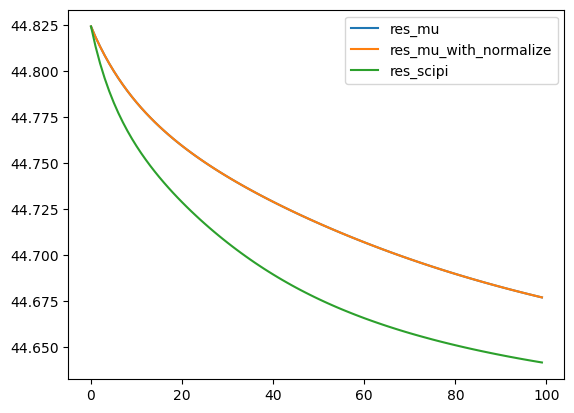

In [14]:
import matplotlib.pyplot as plt
plt.plot(res_mu[3])
plt.plot(res_mu_with_normalize[3])
plt.plot(res_scipi[3])
plt.legend(["res_mu", "res_mu_with_normalize", "res_scipi"])